## Importing the Required Libraries

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import *
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [49]:
# Global Variables for later use

IMAGE_SIZE = 128
BATCH_SIZE = 128
CHANNELS = 3
gpus = tf.config.list_physical_devices('GPU')
gpus

[]

In [50]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # resizing it to 128*128
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img / 255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [51]:
labels = ['real', 'fake']

X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Real
# 1 - Fake
image_path = 'C:\\Users\\VVV333\\PycharmProjects\\real-vs-fake\\train\\' # path containing image samples
# image_path = './dataset/'

In [52]:
s = 0
for folder in os.scandir(image_path):
    for entry in os.scandir(image_path + folder.name):

        X.append(read_and_preprocess(image_path + folder.name + '/' + entry.name))
        
        if folder.name[0] == 'r':
            y.append(0) # real
        else:
            y.append(1) # fake
        s += 1
        if s == 16000:
            s = 0
            break

In [53]:
X = np.array(X)
X.shape # We have 1289 image samples in total

(20000, 128, 128, 3)

In [8]:
y = np.array(y)
y.shape

(24000,)

In [9]:
X

array([[[[0.03921569, 0.03137255, 0.07843138],
         [0.01568628, 0.01960784, 0.03529412],
         [0.01568628, 0.01960784, 0.03137255],
         ...,
         [0.01960784, 0.01568628, 0.03137255],
         [0.01960784, 0.01568628, 0.03137255],
         [0.03529412, 0.03137255, 0.04705882]],

        [[0.00784314, 0.01176471, 0.05490196],
         [0.00784314, 0.00784314, 0.03529412],
         [0.00784314, 0.00392157, 0.03137255],
         ...,
         [0.01568628, 0.01176471, 0.02745098],
         [0.01568628, 0.01176471, 0.02745098],
         [0.01568628, 0.01176471, 0.02745098]],

        [[0.        , 0.00784314, 0.05490196],
         [0.01568628, 0.00392157, 0.04313726],
         [0.00784314, 0.        , 0.03921569],
         ...,
         [0.01176471, 0.00784314, 0.01568628],
         [0.01176471, 0.00784314, 0.02352941],
         [0.01568628, 0.01176471, 0.02745098]],

        ...,

        [[0.00784314, 0.01176471, 0.05098039],
         [0.01960784, 0.01568628, 0.05098039]

## Exploring the Dataset

<BarContainer object of 2 artists>

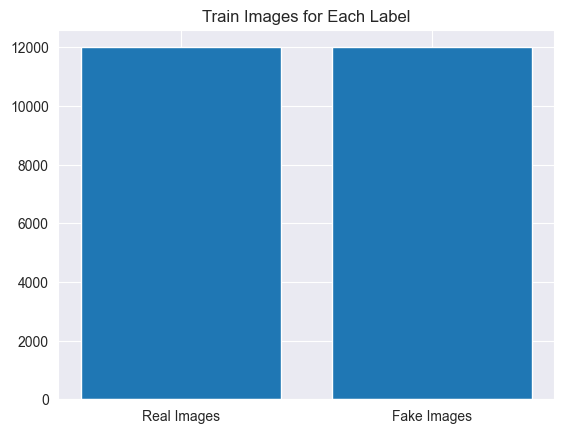

In [10]:
real_count = len(y[y==0])
fake_count = len(y[y==1])

plt.title("Train Images for Each Label")
plt.bar(["Real Images", "Fake Images"],[real_count, fake_count])

# We have more samples of Fake Images than Real Images

In [11]:
# plotting random images

import random

plt.figure(figsize=(16, 16))

# for i in range(12):
#     ax = plt.subplot(3, 4, i + 1)
#     plt.axis("off")
#     img = random.randint(0, 4000)
#     plt.imshow(X[img])
#     plt.title(labels[y[img]])

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

## Splitting the dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [12]:
from sklearn.model_selection import train_test_split

# We have splitted our data in a way that - 
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=123)

In [13]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val,
                                                  test_size=0.5,
                                                  shuffle=True,
                                                  stratify=y_val,
                                                  random_state=123)

In [14]:
# we are using 1031 images for training our model
X_train.shape

(16800, 128, 128, 3)

In [15]:
# we are using 129 images for validating our model
X_val.shape

(3600, 128, 128, 3)

In [16]:
# we are using 129 images for testing our model
X_test.shape

(3600, 128, 128, 3)

In [35]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(8,8), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((4,4)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3,3)),
    
    tf.keras.layers.Flatten(), # flattening for feeding into ANN
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [36]:
# There are 1.1 Million Traininable Parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      12352     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [37]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [38]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights.h5", verbose=1, save_best_only=True)

In [39]:
with tf.device("/device:GPU:1"):
    history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.5915
Epoch 1: val_loss improved from inf to 0.63011, saving model to fakevsreal_weights.h5
132/132 [==============================] - 87s 652ms/step - loss: 0.6721 - accuracy: 0.5915 - val_loss: 0.6301 - val_accuracy: 0.6472
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.6868
Epoch 2: val_loss improved from 0.63011 to 0.57362, saving model to fakevsreal_weights.h5
132/132 [==============================] - 84s 638ms/step - loss: 0.5891 - accuracy: 0.6868 - val_loss: 0.5736 - val_accuracy: 0.7056
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7203
Epoch 3: val_loss improved from 0.57362 to 0.55435, saving model to fakevsreal_weights.h5
132/132 [==============================] - 85s 641ms/step - loss: 0.5505 - accuracy: 0.7203 - val_loss: 0.5544 - val_accuracy: 0.7178
Epoch 4/100
132/132 [====================

KeyboardInterrupt: 

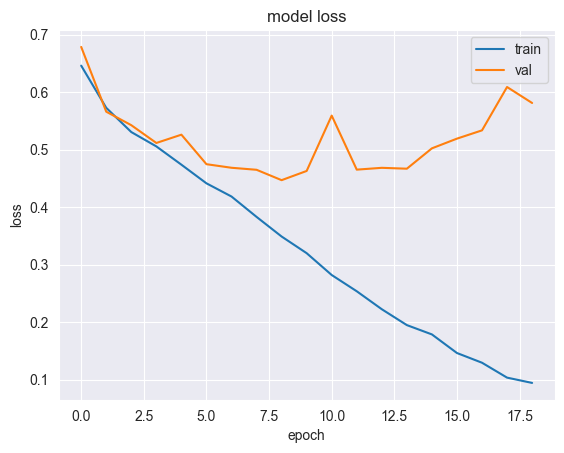

In [40]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [41]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

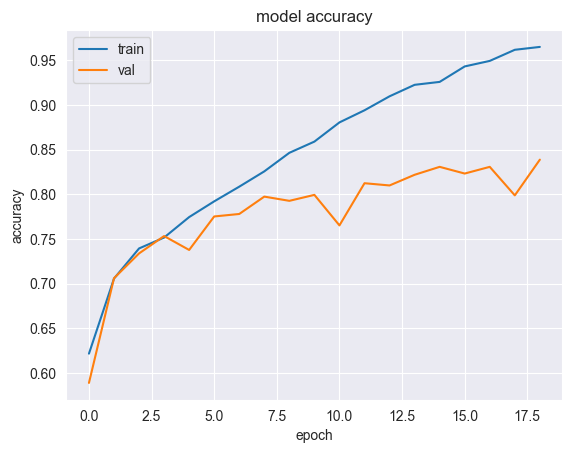

In [42]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [25]:
# Load pretrained model (best saved one)
with open('fakevsreal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model weights  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('fakevsreal_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [43]:
# making predictions
predictions = model.predict(X_test)

In [44]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

113/113 [==============================] - 5s 40ms/step


In [45]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

In [46]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize = (9,7))

group_names = ['Real Images Predicted Correctly','Real Images Predicted as Fake','Fake Images Predicted as Real','Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

0.8136111111111111

<Axes: >

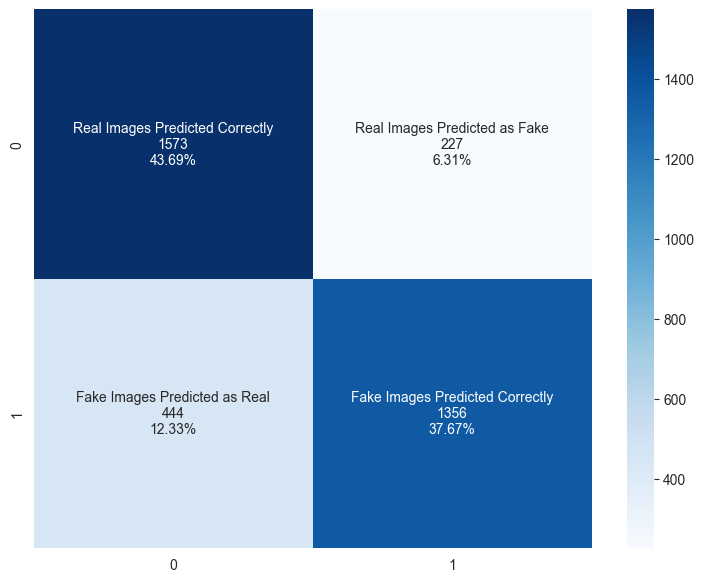

In [47]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)